### Introduction 

In this project we will analyse users events data, with focus on following aims:

- identify the **key users patterns** for product improvement;
- conclude about efficiency of subscription plan to **increace company's money return**. 

#### Progect stages:

1. Data loading and cleaning;
2. **Question 1**: calculation the mean values;
3. **Question 2**: examing groups difference:
 - apply traditional statistical tests; 
 - apply Bayesian methods.
4. **Question 3**: monetization experiments:
 - evaluate subscription plan;
 - calculate revenue return;
 - provide statistical tests.
5. **Summary** for project.

Before data wrangling, we will import main libraries. 

In [1]:
"""
- packages for data manipulation and statistical tests

"""
%matplotlib inline

import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import chi2

In [3]:
"""
- import Plotly modules for interactive data visualization 
- connect to plot inside notebook

"""
from __future__ import division
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

In [132]:
"""
- package for probablistic modelling

"""
import pymc3 as pm

### Data cleaning and preprocessing

In [175]:
events=pd.read_csv('https://s3.amazonaws.com/yousician-public/tests/events.csv')

Now let's see how data looks like and apply main cleaning steps. 

In [176]:
events.head()

,event,uid,group,date
0,app install,7fa732b517cbed14a48843d74526c11a,b,2015-03-04 11:07:41
1,app install,8df707a948fac1b4a0f97aa554886ec8,b,2015-03-04 12:05:36
2,app install,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:09:50
3,account created,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:17:50
4,minigame_played,6e7b33fdea3adc80ebd648fffb665bb8,a,2015-03-04 12:24:50


In [177]:
"""
- drop NaNs if exists from entire frame 

"""
events=events.dropna(how='any')
events.isna().any()

event    False
uid      False
group    False
date     False
dtype: bool

In [178]:
"""
- apply the date type transformation for date

"""
events['date'] = events['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

On this step we will count the number of events and sort them by date to follow the particular user's path more precisely.<br> 
As we are able to see the user can play both song and mini-game multiple times before subscription made. 

In [179]:
"""
- sort values both for uid and date
"""

events=events.groupby(['uid', 'group', 'event', 'date'])['event'].count().reset_index(name='count').sort_values(['uid','date'])
events.groupby(['group', 'event'])['count'].sum().to_frame()

count
group event                 
a     account created    332
      app install        330
      minigame_played   1357
      song_played       1358
      subscribed         201
      unsubscribed        75
b     account created    332
      app install        332
      minigame_played   1349
      song_played       1413
      subscribed         205
      unsubscribed        73
c     account created    331
      app install        330
      minigame_played   1349
      song_played       1313
      subscribed         199
      unsubscribed        76

Below we see that users tend to create accounts more than install apps. 

In [180]:
print('Users, installed app: '+str(events[events['event']=='app install'].shape[0]))
print('Users, created account: '+str(events[events['event']=='account created'].shape[0]))

Users, installed app: 992
Users, created account: 995


**Eye-catching pattern #1**<br>

Based on users events flow we consider user installs app first. <br> 
However as we observe from above, the **users are able to create an account first** and **not install an app** afterwards.

Example of user, who created account only provided below:

In [181]:
"""
- filter per user, that once created an account
"""
uids=events[(events['event']=='app install') | (events['event']=='account created')].groupby(['uid'])['count'].sum()
events[events['uid'].isin(
    list(uids[uids==1].index))].loc[(
    events['uid']=='c3e878e27f52e2a57ace4d9a76fd9acf')]

,uid,group,event,date,count
8338,c3e878e27f52e2a57ace4d9a76fd9acf,c,account created,2015-03-06 11:06:30,1
8345,c3e878e27f52e2a57ace4d9a76fd9acf,c,subscribed,2015-03-08 11:06:30,1
8340,c3e878e27f52e2a57ace4d9a76fd9acf,c,song_played,2015-03-08 11:10:30,1
8341,c3e878e27f52e2a57ace4d9a76fd9acf,c,song_played,2015-03-08 11:13:30,1
8346,c3e878e27f52e2a57ace4d9a76fd9acf,c,unsubscribed,2015-03-10 11:13:30,1
8342,c3e878e27f52e2a57ace4d9a76fd9acf,c,song_played,2015-03-10 11:17:30,1
8343,c3e878e27f52e2a57ace4d9a76fd9acf,c,song_played,2015-03-10 11:24:30,1
8339,c3e878e27f52e2a57ace4d9a76fd9acf,c,minigame_played,2015-03-10 11:32:30,1
8344,c3e878e27f52e2a57ace4d9a76fd9acf,c,song_played,2015-03-11 11:32:30,1


### Question 1: average number of song and minigame_plays before a user subscribes

First we want to learn the mean number of songs and mini-games played before user subscription. <br>
We will use **ranking method** to compare the orders of specific events. 

In [182]:
"""
- use ranking method intra groups, starting from min value 
"""
events['rank'] = events.groupby(['uid'])['date'].rank(method='min')
events.head(5)

,uid,group,event,date,count,rank
1,00411460f7c92d2124a67ea0f4cb5f85,a,app install,2015-03-15 09:08:45,1,1.0
0,00411460f7c92d2124a67ea0f4cb5f85,a,account created,2015-03-15 09:16:45,1,2.0
4,00411460f7c92d2124a67ea0f4cb5f85,a,song_played,2015-03-16 09:16:45,1,3.0
5,00411460f7c92d2124a67ea0f4cb5f85,a,song_played,2015-03-16 09:20:45,1,4.0
2,00411460f7c92d2124a67ea0f4cb5f85,a,minigame_played,2015-03-18 09:20:45,1,5.0


Next we retrieve subscribed users and those who created account or installed an app. To get unique dataframe, we join them, filling NaN values.  

In [183]:
"""
- we need rank column and users id
- join subscribed users to users who played songs/minigames

"""
subscrided=events[events['event']=='subscribed'][['uid', 'rank']].drop_duplicates(subset='uid', keep="first")
subscrided.rename(columns={'rank': 'subscribe_rank'}, inplace=True)

minigame_song=events[(events['event']=='song_played') | (events['event']=='minigame_played')]
minigame_song=minigame_song.set_index('uid').join(subscrided.set_index('uid')).fillna(0)

**Eye-catching pattern #2**

Based on extract below we consider the number of **users**, who **play songs and minigames without subscription**.<br>
For precise measurement we will leave them for now and compute average for already subscribed list. 

In [184]:
minigame_song[minigame_song.index=='00ac8ed3b4327bdd4ebbebcb2ba10a00']

,group,event,date,count,rank,subscribe_rank
uid,,,,,,
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,song_played,2015-03-14 14:20:29,1,3.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,song_played,2015-03-14 14:25:29,1,4.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,minigame_played,2015-03-14 14:30:29,1,5.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,minigame_played,2015-03-15 14:30:29,1,6.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,song_played,2015-03-17 14:30:29,1,7.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,minigame_played,2015-03-17 14:35:29,1,8.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,minigame_played,2015-03-18 14:35:29,1,9.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,minigame_played,2015-03-19 14:35:29,1,10.0,0.0
00ac8ed3b4327bdd4ebbebcb2ba10a00,b,song_played,2015-03-21 14:35:29,1,11.0,0.0


In [185]:
"""
- use rank column to filter users, who plyed songs/minigames before subscription

"""
minigame_song=minigame_song[minigame_song.apply(lambda df: (df['rank']!=0) & (df['rank'] < df['subscribe_rank']), axis=1)]
pd.pivot_table(minigame_song, index=['group', 'uid', 'event'],
               values='count', aggfunc=np.sum).fillna(0).head()

count
group uid                              event                 
a     00411460f7c92d2124a67ea0f4cb5f85 minigame_played      2
                                       song_played          4
      00ec53c4682d36f5c4359f4ae7bd7ba1 minigame_played      1
                                       song_played          2
      01386bd6d8e091c2ab4c7c7de644d37b minigame_played      4

#### Average number of songs and mini-games played per user

Now we are ready to calculate the average number of events in specific group and across all groups. Then, plot a bar chart to represent result.  

In [186]:
user_mean=pd.pivot_table(minigame_song, index=['group', 'uid'], columns=['event'],
               values='count', aggfunc=np.sum).fillna(0).groupby('group').mean()
user_mean

event,minigame_played,song_played
group,,
a,2.184049,2.306748
b,2.177515,2.278107
c,2.018293,2.012195


In [187]:
trace1 = go.Bar(
    x=list(user_mean.index),
    y=user_mean['minigame_played'].values,
    name=user_mean.columns[0],
    text=user_mean['minigame_played'].values.round(3),
    textposition = 'inside',
    marker = dict(
        color = '#9f25ea',
        line = dict(
            width = 2,
            color = 'rgb(8,48,107)'
        )
    )
)
trace2 = go.Bar(
    x=list(user_mean.index),
    y=user_mean['song_played'].values,
    name=user_mean.columns[1],
    text=user_mean['song_played'].values.round(3),
    textposition = 'inside',
        marker = dict(
        color = '#7196ed',
        line = dict(
            width = 2,
            color = 'rgb(8,48,107)'
        )
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Average played songs/mini-games per User',
    showlegend=True
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [188]:
round(pd.pivot_table(minigame_song, index=['uid'], columns=['event'],
               values='count', aggfunc=np.sum).fillna(0).mean(), 2)

event
minigame_played    2.13
song_played        2.20
dtype: float64

#### Result #1

Overall mean values before subscribed - **2.13** and **2.20** for minigames/songs.<br>
We see the the unsignificant defference for group A and B in terms of songs/minigames played - around 2.3 and 2.2 relatively for songs/games. The avegare for group C is seemed to have smaller value: 2.01 for songs and 2.02 for games.

### Question 2: Does group B has a better conversion rate than control group A?

Before conversion calculation we will display **the events funnel** with number of **first occurences** of users events - actions, made by user first time.<br>
We will apply *nunique()* method for entire dataframe. 

In [189]:
"""
- create a pivot table, displaying columns as events
"""
occurence=events.groupby(['group', 'event'])['uid'].nunique().reset_index(name='value')
occurence=pd.pivot_table(occurence, index=['group'], columns = ['event'], values='value')
occurence

event,account created,app install,minigame_played,song_played,subscribed,unsubscribed
group,,,,,,
a,332,330,322,327,201,75
b,332,332,328,331,205,73
c,331,330,323,324,199,76


Add a total column and calculate a **percentage ratio**.

In [190]:
occurence['users_total']=events.groupby(['group'])['uid'].nunique()
ratio = np.round(occurence*100.0/occurence.iloc[-1, -1], 1)
ratio

event,account created,app install,minigame_played,song_played,subscribed,unsubscribed,users_total
group,,,,,,,
a,99.7,99.1,96.7,98.2,60.4,22.5,100.0
b,99.7,99.7,98.5,99.4,61.6,21.9,100.0
c,99.4,99.1,97.0,97.3,59.8,22.8,100.0


#### General Approach

We will calculate the conversion of first events made, **ignoring the sequence of follow-up user action**. <br>
For instance: first song played after account created, **no matter how many steps occured between** these two events. 

In [191]:
def conversion_general(action_next, action_prev):
    second=events[events['event']==action_next][['uid', 'rank']].drop_duplicates(subset='uid', keep="first")
    second.rename(columns={'rank': action_next+'_rank'}, inplace=True)
    # join the dataframe with action made afterwards
    first=events[events['event']==action_prev]
    first=first.set_index('uid').join(second.set_index('uid')).fillna(0)
    # we filter the users who did't perform next action 
    # besides we choose the rank higher by one - means action right after previous
    first=first[first.apply(lambda df: (df['rank']!=0) & (df['rank'] < df[action_next+'_rank']),
                                                          axis=1)]
    first=first.reset_index()
    conversion=first.groupby(['uid', 'group'])['count'].nunique().reset_index()
    total_conv=pd.pivot_table(conversion, columns = ['group'], values='count', aggfunc=np.sum)

    conversion_vector=np.round(total_conv/ occurence[action_prev]*100, 2)

    return conversion_vector, conversion, first

In [192]:
"""
- apply defined function to events pairs and perform in table 

"""
conversion_gen=pd.DataFrame()
conversion_gen['group']=conversion_general('song_played', 'account created')[0].columns.values
conversion_gen['account_to_install']=conversion_general('account created', 'app install')[0].iloc[0,:].values
conversion_gen['songs_to_account']=conversion_general('song_played', 'account created')[0].iloc[0,:].values
conversion_gen['minigame_to_account']=conversion_general('minigame_played', 'account created')[0].iloc[0,:].values
conversion_gen['songs_to_subscription']=conversion_general('subscribed', 'song_played')[0].iloc[0,:].values
conversion_gen['minigame_to_subscription']=conversion_general('subscribed', 'minigame_played')[0].iloc[0,:].values
conversion_gen['churn_rate']=np.round(occurence['unsubscribed'].values/occurence['subscribed'].values*100,2)

In [193]:
conversion_gen

,group,account_to_install,songs_to_account,minigame_to_account,songs_to_subscription,minigame_to_subscription,churn_rate
0,a,99.70,98.19,96.69,42.81,43.48,37.31
1,b,99.70,99.40,98.49,44.71,45.12,35.61
2,c,99.39,97.28,96.98,42.90,43.03,38.19


We see the conversion rate in **group B** is **slightly higher** than rate in control group (**99.40%** versus **98.19%**). <br>
To draw the conclusion about statistical difference let's apply tests on Group A and Group B. 

We start with hypothesis setting:

$H_0$: the groups are not significantly different in terms of conversion; <br>
$H_a$: experimental and control group possess statistical difference.

The test will be prepared at **5%** signifinace level.
   

In [194]:
acc_creators=events[events['event']=='account created'].groupby(['uid', 'group'])['count'].nunique().reset_index()
conversed=conversion_general('song_played', 'account created')[1][['uid', 'count']]
conversed.rename(columns={'count': 'is_success'}, inplace=True)
total=acc_creators.set_index('uid').join(conversed.set_index('uid')).fillna(0)

# now we split experiments into A and B
a=list(total[total['group']=='a']['is_success'])
b=list(total[total['group']=='b']['is_success'])

#### Test 1: $\chi$-squared statistic

Apply frequentist inference to draw a conclusion about difference. 

In [195]:
"""
- create 2x2 matrix as contingency table
- assume probability difference for 1 and 0 choice between groups
- use  chi2_contingency() from stats module to estimate chi-squared statistic

"""

T = np.zeros((2, 2)).astype(np.float32)
for i,j in zip(a,b):
    T[0][0] += i!=0
    T[0][1] += i!=1
    T[1][0] += j!=0
    T[1][1] += j!=1
c2=scipy.stats.chi2_contingency(T, correction=False)

In [196]:
print('p_value=%.3f' % (c2[1]))

if c2[1]>0.05:
    print('Failed to reject null-hypothesis: groups are not statistically different')
else:
    print('H-null hypothesis is rejected: groups are statistically different')
    
    
trace0 = go.Table(
  header = dict(
    values = [['Group'],
              ['Successes'],
              ['Failures']],
    line = dict(color = '#506784'),
    fill = dict(color = '#845def'),
    align = ['left','center'],
    font = dict(color = 'white', size = 12)
  ),
  cells = dict(
    values = [
      ['Group A', 'Group B'],
      [T[0][0], T[1][0]],
      [T[0][1], T[1][1]]],
    line = dict(color = '#506784'),
    fill = dict(color = ['#f5f4f7','#f5f4f7']),
    align = ['left', 'center'],
    font = dict(color = '#506784', size = 11)
    ))
layout1 = dict(
    width=800,
    height=250,
    autosize=False,
    title='Contingency table for groups A and B',
    margin=go.layout.Margin(
        l=80,
        r=50,
        b=90,
        t=50,
        pad=2
    ))

fig = dict(data=[trace0], layout=layout1)

iplot(fig)

p_value=0.155
Failed to reject null-hypothesis: groups are not statistically different


As we obtained from analysis above, the conversion **difference** between control and experimental groups **is not significant**.<br>
But the regular business cases often require to conclude about **probabilities of particular results** to support our beliefs.<br> Moreover, we see that number of failures to converse in B is slightly less than in A. 

#### Test 2: Bayesian inference

Next lets perform Bayesian method for hypothesis testing using **PyMC3** library. 

In [35]:
a = [round(x) for x in a]
b = [round(x) for x in b]
print("Observations group A: ", a[:15], "...")
print("Observations group B: ", b[:15], "...")

Observations group A:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...
Observations group B:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ...


In [43]:
"""
- model setting, assuming uniform priors for p_A and p_B
- apply "Metropolis" algorithm for sampling 

"""
with pm.Model() as model:
    prob_A = pm.Uniform("prob_A", 0, 1)
    prob_B = pm.Uniform("prob_B", 0, 1)
    
    # define the deterministic function of delta
    delta = pm.Deterministic("delta", prob_A - prob_B)

    
    # define the sets of observations 
    obs_A = pm.Bernoulli("obs_A", prob_A, observed=a)
    obs_B = pm.Bernoulli("obs_B", prob_B, observed=b)

    # results are kept in trace variable 
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [prob_B]
>Metropolis: [prob_A]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 41000/41000 [04:12<00:00, 162.25draws/s]
The number of effective samples is smaller than 25% for some parameters.


Probability group A conversion is worse than group B: 0.913
Probability group A conversion is better than group B: 0.087


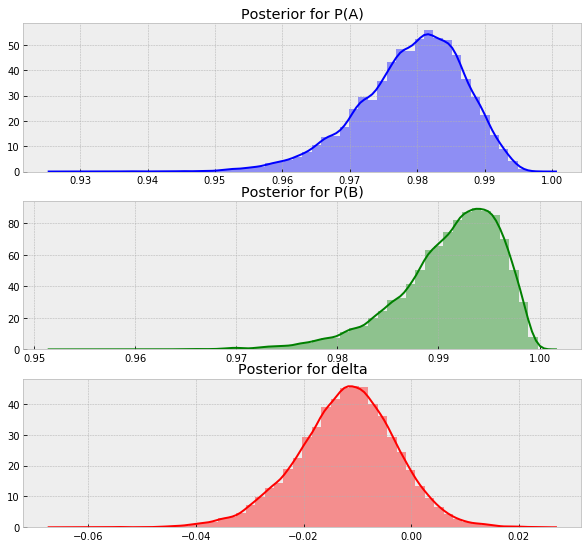

In [44]:
p_A_samples = trace["prob_A"]
p_B_samples = trace["prob_B"]
delta_samples = trace["delta"]

"""
- count observations less than 0, 
- example: the area under the curve before 0, represent the probability that group A is worse than B 
"""

print("Probability that group A conversion is worse than group B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability that group A conversion is better than group B: %.3f" % \
    np.mean(delta_samples > 0))

plt.style.use('bmh')
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False,
                       figsize=(10,8))
plt.subplots_adjust(top=1.0)
sns.distplot(p_A_samples, kde=True, color="b", ax=axs[0]).set_title('Posterior for P(A)')
sns.distplot(p_B_samples, kde=True, color="g", ax=axs[1]).set_title('Posterior for P(B)')
sns.distplot(delta_samples, kde=True, color="r", ax=axs[2]).set_title('Posterior for delta')

plt.show()

We see the majority of "delta" **posterior distribution lies below 0**, implying the **group B is better than A** in terms of conversion rate.

#### Results#2 

**Group B is better than Group A.**<br>
Alhough the chi-squared test showed the stistically insignificance in groups difference, Bayesian test determines the high probability that Group B performs better than Group A.<br>
This makes sense in terms of business: voiceovers **implementation for group B resulted a slightly better conversion rate**, that drives our expectations about experiment return.

### Additional note: Funnel chart  for group B

Additionally, we are able to clculate the number of users, who perform actions on each step, interacting with products and represent the funnel chart: 

1. The number of users, who **created account** once **app installed**;
2. The number of users, who **played songs** after **creating an account and app installation**;
2. **Subscribed** users who **produced all the steps above**.

Note, in this case we are mostly interested in **sequence of user's actions**: the measures listed above represents the number of **actions** made **after particular event** was occured.<br>
For instance, the users are available to play songs after account creation, as well as after playing mini-games or making subscription. However it's important to track certain **preceding event**. 

**Why does the order matter?**

1) Better understanding of **users behaviour** and specific patterns, effecting on their next step;<br>
2) Preferences investigation: highly meaningful for **interaction with product**, user journey and experience analysis;<br>
3) Different **products/layouts testing** to improve users attraction.

Initiate two functions, maintaining the sequencial calculations: 
 - retrieve the count for **next event**;
 - adding result to **preceeding event**. 

In [197]:
"""
- next_rank: return the unique frame for event, that occured afterwards
- append_next: append next_rank result to dataframe of previous event
"""
def next_rank(event):
    frame_next=events[events['event']==event][['uid', 'rank']].drop_duplicates(
        subset='uid', keep="first")
    frame_next.rename(columns={'rank': event+'_rank'}, inplace=True)
    return frame_next

def append_next(prev_frame, prev_event, next_frame, next_event):
    res=prev_frame.set_index('uid').join(next_frame.set_index('uid')).fillna(0)
    res=res[res.apply(lambda df: (df[prev_event+'_rank']!=0) & (df[prev_event+'_rank']< df[next_event+'_rank']),
                                                           axis=1)]
    event_seq=res.reset_index()
    event_seq=event_seq.groupby(['uid', 'group'])['count'].nunique().reset_index()
    event_seq=pd.pivot_table(event_seq, columns = ['group'], values='count', aggfunc=np.sum)
    return event_seq, res.reset_index()

Now we apply the derived function to events and build a funnel chart for experiment group B. 

In [198]:
start_frame=events[events['event']=='app install']
start_frame.rename(columns={'rank': 'app install_rank'}, inplace=True)
acc_to_app=append_next(start_frame, 'app install', next_rank('account created'), 'account created')
song_to_acc=append_next(acc_to_app[1], 'account created', next_rank('song_played'), 'song_played')
sub_to_song=append_next(song_to_acc[1], 'song_played', next_rank('subscribed'), 'subscribed')

#### Funnel chart creation 

In [199]:
value1=occurence['app install'][1]
value2=acc_to_app[0].iloc[:,1]
value3=song_to_acc[0].iloc[:,1]
value4=sub_to_song[0].iloc[:,1]

In [200]:
# shortlist values and phases 
values = [value1, value2, value3, value4]
values = [int(x) for x in values]
phases = ['App install', 'Account create', 'Song play', 'Subscribed']

# difine colors 
colors = ['rgb(143, 95, 160)', 'rgb(113, 95, 160)', 'rgb(88, 186, 183)', 'rgb(78, 216, 135)']
n_phase = len(phases)
plot_width = 400

# properties of sections (height and difference between)
section_h = 150
section_d = 10

# multiplicating width of other sections
unit_width = plot_width / max(values)

# width of each funnel section relative to the plot width
phase_w = [int(value * unit_width) for value in values]

# plot height based on the number of sections and the gap in between them
height = section_h * n_phase + section_d * (n_phase - 1)
# list containing all the plot shapes
shapes = []

# list containing the Y-axis location for each section's name and value text
label_y = []

for i in range(n_phase):
        if (i == n_phase-1):
                points = [phase_w[i] / 2, height, phase_w[i] / 2, height - section_h]
        else:
                points = [phase_w[i] / 2, height, phase_w[i+1] / 2, height - section_h]

        path = 'M {0} {1} L {2} {3} L -{2} {3} L -{0} {1} Z'.format(*points)
        shape = {
                'type': 'path',
                'path': path,
                'fillcolor': colors[i],
                'line': {
                    'width': 1,
                    'color': colors[i]
                }
        }
        shapes.append(shape)
        
        # Y-axis location for this section's details (text)
        label_y.append(height - (section_h / 2))

        height = height - (section_h + section_d)
# plot phases names
label_trace = go.Scatter(
    x=[-350]*n_phase,
    y=label_y,
    mode='text',
    text=phases,
    textposition='top right',
    textfont=dict(
        color='rgb(200,200,200)',
        size=15
    ),
)
 
# plot values 
value_trace = go.Scatter(
    x=[350]*n_phase,
    y=label_y,
    mode='text',
    text=values,
    textposition='top left',
    textfont=dict(
        color='rgb(200,200,200)',
        size=15,
    ),
)

data = [label_trace, value_trace]
 
layout = go.Layout(
    title="Funnel Chart - Group B",
    titlefont=dict(
        size=20,
        color='rgb(203,203,203)'
    ),
    shapes=shapes,
    height=560,
    width=800,

    showlegend=False,
    paper_bgcolor='rgba(44,58,71,1)',
    plot_bgcolor='rgba(44,58,71,1)',
    xaxis=dict(
        showticklabels=False,
        zeroline=False,
    ),
    yaxis=dict(
        showticklabels=False,
        zeroline=False,
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Question №3: is the experiment of the group C bringing more money to the company?

We start with adding revenue metric to our analysis. Next we will compare the difference between control group A and experimenal C to test the difference in churn rate and average revenue per user. 

The observation period is starting from first subscribed date to end up date. 
End up data of period:
- for already **unsubscribed** users: the **last date of their subscription**; 
- for **valid subscription** user: the **last date** in **initial dataframe**. 

In [201]:
subscribed=events[(events['event']=='subscribed')]
unsubscribed=events[events['event']=='unsubscribed'][['uid', 'date']].drop_duplicates(subset='uid', keep="first")
unsubscribed.rename(columns={'date': 'end'+'_date'}, inplace=True)
# join the dataframe with action made afterwards
subscribed=subscribed.set_index('uid').join(unsubscribed.set_index('uid')).fillna(events['date'].max())
subscribed=subscribed[(subscribed['group']=='a') |(subscribed['group']=='c')].reset_index()

In [202]:
start=subscribed['date'].min()
end=events['date'].max()
duration=end-start
print('First subscription date: '+str(start))
print('End period date: '+str(end))
print('Observed period in days: '+str(duration.days))

First subscription date: 2015-03-04 13:15:38
End period date: 2015-04-09 19:27:00
Observed period in days: 36


Then we group by date (week) and count number subscribed and unsibscribed users for both groups and add charges plan.
Apply ***date_range()*** method to list the dates between. 

In [203]:
date = [pd.Series(pd.date_range(row[1].date, row[1].end_date)) for row in subscribed[['date', 'end_date']].iterrows()]
diff = [len(x) for x in date]
date = pd.Series(pd.concat(date).values, name='current_date')
result = pd.DataFrame(np.repeat(subscribed.values, diff, axis=0), columns=subscribed.columns)
result = pd.concat([date, result], axis=1)

Assume the following payments system for both groups:

- Group A: **5 EUR payment in advance**, weekly (charges collected **once week started**);
- Group A: **0.8 EUR payment in advance**, daily (charges collected **once day started**).

In [204]:
result.head()

,current_date,uid,group,event,date,count,rank,end_date
0,2015-03-18 09:39:45,00411460f7c92d2124a67ea0f4cb5f85,a,subscribed,2015-03-18 09:39:45,1,9,2015-04-09 19:27:00
1,2015-03-19 09:39:45,00411460f7c92d2124a67ea0f4cb5f85,a,subscribed,2015-03-18 09:39:45,1,9,2015-04-09 19:27:00
2,2015-03-20 09:39:45,00411460f7c92d2124a67ea0f4cb5f85,a,subscribed,2015-03-18 09:39:45,1,9,2015-04-09 19:27:00
3,2015-03-21 09:39:45,00411460f7c92d2124a67ea0f4cb5f85,a,subscribed,2015-03-18 09:39:45,1,9,2015-04-09 19:27:00
4,2015-03-22 09:39:45,00411460f7c92d2124a67ea0f4cb5f85,a,subscribed,2015-03-18 09:39:45,1,9,2015-04-09 19:27:00


Apply weekly monetization sheme for group A.

In [205]:
a_revenue=result[result['group']=='a']
a_revenue = a_revenue.groupby('uid').apply(lambda x: x.set_index('current_date').resample('7D').first().reset_index())
a_revenue=a_revenue.reset_index(drop=True)
a_revenue['charge_amount']=5.0

Perform daily charges for group C.

In [206]:
c_revenue=result[result['group']=='c']
c_revenue['charge_amount']=0.8

Display the total and average revenue in two groups. 

In [207]:
a_total=a_revenue['charge_amount'].sum()
a_average=a_total/len(a_revenue['uid'].unique())

c_total=c_revenue['charge_amount'].sum()
c_average=c_total/len(c_revenue['uid'].unique())

print('Total revenue from group A: '+str(a_total))
print('Avegare revenue per user in group A: '+str(round(a_average,2)))

print('Total revenue from group C: '+str(c_total))
print('Avegare revenue per user in group C: '+str(round(c_average,2)))

Total revenue from group A: 2975.0
Avegare revenue per user in group A: 14.8
Total revenue from group C: 2768.8
Avegare revenue per user in group C: 13.91


#### Test 1: $\chi$-squared for churn rate

Let's test the difference in churn rate between groups:

$H_0$: the A and C groups are not significantly different in terms of churn; <br>
$H_a$: experimental and control group perfroms statistical difference.

In [208]:
T_churn = np.zeros((2, 2)).astype(np.float32)

T[0][0] = occurence.iloc[:, -3][0]- occurence.iloc[:, -2][0]
T[0][1] = occurence.iloc[:, -2][0] # number of unsubscribed in A
T[1][0] = occurence.iloc[:, -3][2] - occurence.iloc[:, -2][2]
T[1][1] = occurence.iloc[:, -2][2] # number of unsubscribed in C
c2=scipy.stats.chi2_contingency(T, correction=False)

print('p_value=%.3f' % (c2[1]))

if c2[1]>0.05:
    print('Failed to reject null-hypothesis: groups are not statistically different')
else:
    print('H-null hypothesis is rejected: groups are statistically different')

p_value=0.856
Failed to reject null-hypothesis: groups are not statistically different


Results of test shows the **unsignificant difference in churn rate** between A and C. Continue with **applying t-test** for mean charges comparison.

#### Test 2: *t-test* for payment means 

$H_0$: the user payment means are same in group A and C ; <br>
$H_a$: the user payment means differ from one another.

In [209]:
obs_a=list(a_revenue.groupby(['uid'])['charge_amount'].sum())
obs_c=list(c_revenue.groupby(['uid'])['charge_amount'].sum())

Since we don't assume equal variances between groups, we will conduct Welch’s t-test, that also available under *stats.ttest_ind()* functionality.

In [210]:
t_test=stats.ttest_ind(a= obs_a,
                b= obs_c,
                equal_var=False)
print('p_value=%.3f' % (t_test[1]))

if t_test[1]>0.05:
    print('Failed to reject null-hypothesis: means are not statistically different')
else:
    print('H-null hypothesis is rejected: payment means differ from one another')

p_value=0.321
Failed to reject null-hypothesis: means are not statistically different


Independent groups test presents that groups means are not statistically different. 

####  Test 3: *t-test* for lifetime means 

$H_0$: the average lifetime value is the same for group A and C ; <br>
$H_a$: the groups differ in terms of mean lifetime value

In [211]:
lf_a=result[result['group']=='a']
lf_c=result[result['group']=='c']

# calculating the difference between end date and subscription date 
delta_a = list((lf_a['end_date'] - lf_a['date']).astype('timedelta64[D]'))
delta_c = list((lf_c['end_date'] - lf_c['date']).astype('timedelta64[D]'))

t_test=stats.ttest_ind(a= delta_a,
                b= delta_c,
                equal_var=False)
print('p_value=%.3f' % (t_test[1]))

if t_test[1]>0.05:
    print('Failed to reject null-hypothesis: means are not statistically different')
else:
    print('H-null hypothesis is rejected: lifetime means differ from one another')

p_value=0.180
Failed to reject null-hypothesis: means are not statistically different


Finally plot **cummulative sum of revenue** we return daily with respect of users count.

In [212]:
rev=c_revenue.groupby(['current_date'])['charge_amount'].sum().reset_index()
users=c_revenue.groupby(['uid', 'count'])['charge_amount'].sum().reset_index()

In [213]:
rev_cum = np.cumsum(list(rev['charge_amount']))
user_cum= np.cumsum(list(users['count']))
user_cumrev= np.cumsum(list(users['charge_amount']))

trace1 = go.Scatter(x=rev_cum, y=rev['current_date'],
                    marker=dict(color='rgb(51, 51, 153)'),
                    name='Cumulative revenue'
)
trace2 = go.Scatter(x=user_cumrev, y=user_cum,
                     marker=dict(color='rgb(150, 25, 120)'),
                  fill='tozeroy',
                   yaxis='y2',
                name='Users count'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Daily Payments vs Subscribers for Group C',
    yaxis=dict(
        title='Date'
    ),
    yaxis2=dict(
        title='Users count',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    ),
    width=1000,
    height=500,
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

**Result #3** 

The overall **payments sum in group C is lower** than in control group. The test statistic represents the unsignificant difference (at 5% and 10% levels) between payment means. Hence the experimential scheme in **group C seems not efficient** in terms of money return. 

### Summary

1. The avegare number of songs/minigames played per user before subscribed: **2.13** for minigames and **2.2** for songs.
2. Although there is no statistically difference between Group A nd B, **Group B presents better conversion**, where users more likely tend to choose play songs, that strongly supported by Bayesian interference. 
3. **Group C is less efficient** than control in terms of revenue return. 

In [214]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>